In [69]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

from mealpy import FloatVar, ABC
from scipy.spatial.distance import cdist

In [70]:
pca_data = pd.read_csv("cpa_data.csv")
pca_data.head()


,fecha,referencia,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
0,06/04/01,P1,-2.172840,-0.521445,-0.444831,-0.162855,-0.399744,-0.048975,-0.092430,-0.233617,-0.031675,0.210330
1,06/04/01,P2,-1.989673,-0.561169,0.142021,0.416451,-0.991852,0.092949,0.053050,0.800244,-0.385982,-0.617666
2,06/04/01,P3,-2.154176,-0.100730,-0.214204,0.996446,0.892430,0.249675,-0.490614,-0.794934,0.128861,1.030285
3,06/04/01,P4,-2.238051,-0.316221,-1.208847,-0.959316,-0.314796,-0.046410,0.342104,-0.369822,0.130015,0.186329
4,07/04/01,P1,-2.375187,-0.322874,-0.971796,-0.991752,-0.346266,-0.070763,0.227969,-0.403109,0.282735,0.107680


## Entrenamiento para clasificación con K-Means

Para realizar un entrenamiento no supervisado con una base de datos de parámetros químicos, la mejor opción es utilizar un Mapa Auto-Organizado (SOM) o un Autoencoder. Sin embargo, dado que ya tienes los Componentes Principales (PCA), la técnica más robusta y estándar para encontrar grupos (clusters) es el K-Means Clustering potenciado por una Red Neuronal para validación.

### Preparación de los datos (Inputs del PCA)

Usaremos los componentes que explican la mayor parte de la varianza (según tu tabla, los primeros 5 o 6 son los más informativos).

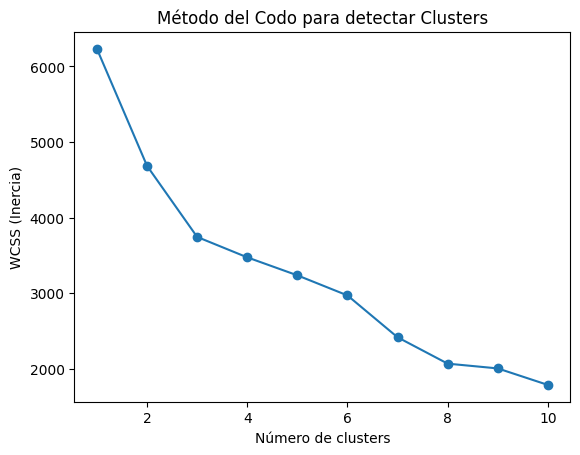

In [71]:
# Usamos los resultados del PCA (asumiendo que df_pca tiene tus componentes)
# Seleccionamos, por ejemplo, los primeros 5 componentes principales
X_unsupervised = pca_data.iloc[:, 2:8] 

# Determinamos el número óptimo de clusters (Método del Codo)
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(X_unsupervised)
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 11), wcss, marker='o')
plt.title('Método del Codo para detectar Clusters')
plt.xlabel('Número de clusters')
plt.ylabel('WCSS (Inercia)')
plt.show()

### Entrenamiento del Modelo de Clasificación

Una vez identificado el número de grupos (supongamos que el "codo" está en 3 o 4 clusters), ejecutamos el entrenamiento final.

In [72]:
# Entrenamos con el número de clusters elegido (ejemplo: 4)
n_clusters_optimo = 4
model = KMeans(n_clusters=n_clusters_optimo, init='k-means++', random_state=42)
clusters = model.fit_predict(X_unsupervised)

# Añadimos la clasificación a nuestro DataFrame original
# data_fixed['cluster_id'] = clusters

### Gráfico de Dispersión 2D (Visualización Estándar)

Primero, asegúrate de tener en un solo lugar los componentes y las etiquetas de los clusters que generó el modelo.

In [73]:
# Creamos un DataFrame auxiliar para graficar
cp_grafico = ['PC1', 'PC3']
df_grafico = pca_data[cp_grafico].copy()
df_grafico['Cluster'] = clusters # Las etiquetas que generó tu modelo K-Means

# Agregamos una columna de texto para que la leyenda sea más clara
df_grafico['Cluster_Name'] = df_grafico['Cluster'].apply(lambda x: f'Grupo {x}')


Este gráfico te permitirá ver cómo el algoritmo separó las muestras de agua. Si los grupos están bien definidos, verás "nubes" de puntos de distintos colores.

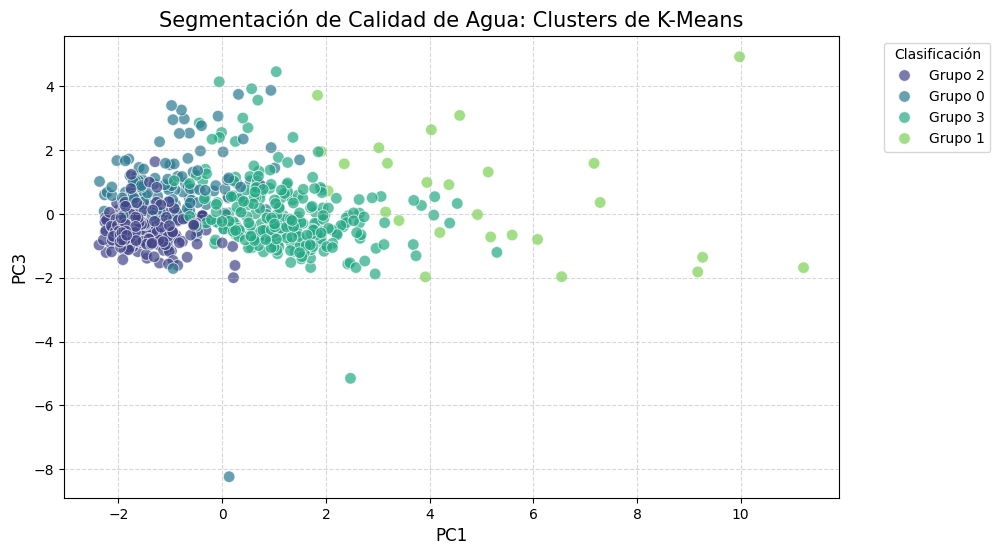

In [74]:
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df_grafico, 
    x=cp_grafico[0], 
    y=cp_grafico[1], 
    hue='Cluster_Name', 
    palette='viridis', 
    s=70, 
    alpha=0.7,
    edgecolor='w'
)

# Personalización de títulos (basado en tu interpretación de loadings)
plt.title('Segmentación de Calidad de Agua: Clusters de K-Means', fontsize=15)
plt.xlabel(f'{cp_grafico[0]}', fontsize=12)
plt.ylabel(f'{cp_grafico[1]}', fontsize=12)
plt.legend(title='Clasificación', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

## Entrenamiento con Autoencoder

In [75]:
# pendiente

### Híbrido ABC + K-Means (Refinamiento)
En este modelo, el ABC se encarga de la exploración global y el K-Means de la explotación local.

1. Fase Global (ABC): Las abejas exploran el espacio de datos para encontrar regiones prometedoras donde podrían estar los clusters.

2. Fase Local (K-Means): Una vez que el ABC encuentra una solución cercana a la óptima, se utiliza el operador de K-Means para "pulir" esos centroides y ajustarlos rápidamente a los datos circundantes.

Resultado: Es mucho más rápido que el ABC puro y más preciso que el K-Means solo.


### El Flujo de Trabajo

La idea central es usar el ABC para inicializar de forma inteligente los centroides y luego dejar que K-Means termine el trabajo sucio de convergencia.

1. Inicialización (Abejas Exploradoras)En lugar de elegir puntos al azar, generas una población de "abejas". Cada abeja lleva consigo un vector que representa los centros de los $k$ clusters.

- Población: $N$ soluciones potenciales.
- Posición: Coordenadas de los centros de los grupos en el espacio de datos.2. Ciclo de 

2. Optimización Global (Fase ABC)Durante un número determinado de iteraciones, las abejas realizan tres tareas:
- Abejas Empleadas: Buscan nuevas soluciones cerca de las actuales (modifican un poco los centros) para ver si el error (SSE) disminuye.
- Abejas Observadoras: Eligen las mejores soluciones encontradas basándose en una probabilidad de "fitness". Entre mejor sea el clustering, más abejas irán a esa zona.
- Abejas Exploradoras: Si una solución no mejora después de varios intentos, la abeja la abandona y vuela a una zona totalmente nueva del dataset para evitar el estancamiento.

3. El "Salto" a K-Means (Refinamiento Local)Una vez que el algoritmo ABC ha convergido en una región prometedora (es decir, ya tenemos centros muy cercanos a los reales), tomamos la mejor abeja y usamos sus posiciones como el init de un algoritmo K-Means tradicional.

4. FinalizaciónK-Means realiza sus iteraciones finales (que suelen ser muy pocas en este punto) para asegurar que cada punto esté asignado al centroide más cercano de forma exacta.

```bash
# 1. Fase Global (Exploración con ABC)
for iteracion in rango(max_iter_abc):
    for abeja in poblacion:
        nueva_posicion = mover_abeja(abeja)
        evaluar_fitness(nueva_posicion) # Usando Suma de Errores Cuadráticos
    manejar_abejas_exploradoras() # Evita mínimos locales

# 2. Selección del Ganador
mejor_solucion = obtener_mejor_abeja(poblacion)

# 3. Fase Local (Refinamiento con K-Means)
# Usamos la mejor posición del ABC como semilla
kmeans_final = KMeans(n_clusters=k, init=mejor_solucion.centros)
kmeans_final.fit(datos)
```

In [92]:
data = pca_data.drop(columns=['fecha', 'referencia']).copy()

n_clusters = 4
n_features = data.shape[1]

# 2. Función de Aptitud (Fitness)
def fitness_function(solution):
    centroids = solution.reshape((n_clusters, n_features))
    distances = cdist(data, centroids, 'euclidean')
    labels = np.argmin(distances, axis=1)
    
    # Penalización si se pierde un cluster
    if len(np.unique(labels)) < n_clusters:
        return 1e18
    
    # Cálculo de SSE (Suma de errores cuadráticos)
    sse = 0
    for i in range(n_clusters):
        cluster_points = data[labels == i]
        sse += np.sum((cluster_points - centroids[i])**2)
    return sse

# 3. Configuración del Problema
low_bounds = np.min(data, axis=0).tolist() * n_clusters
up_bounds = np.max(data, axis=0).tolist() * n_clusters

problem_dict = {
    "obj_func": fitness_function,
    "bounds": FloatVar(lb=low_bounds, ub=up_bounds),
    "minmax": "min",
}

# 4. Ejecución de ABC
model = ABC.OriginalABC(epoch=100, pop_size=100)

# CORRECCIÓN AQUÍ: Obtenemos el objeto 'g_best' (Global Best Agent)
g_best = model.solve(problem_dict)

# Extraemos la posición y el fitness del objeto Agent
best_pos = g_best.solution 
best_fit = g_best.target.fitness

print(f"Mejor Fitness (SSE) encontrado por ABC: {best_fit}")


2026/02/28 10:26:43 PM, INFO, mealpy.swarm_based.ABC.OriginalABC: OriginalABC(epoch=100, pop_size=100, n_limits=25)


2026/02/28 10:26:43 PM, INFO, mealpy.swarm_based.ABC.OriginalABC: >>>Problem: P, Epoch: 1, Current best: 39360.26674462181, Global best: 39360.26674462181, Runtime: 0.29710 seconds
2026/02/28 10:26:44 PM, INFO, mealpy.swarm_based.ABC.OriginalABC: >>>Problem: P, Epoch: 2, Current best: 39360.26674462181, Global best: 39360.26674462181, Runtime: 0.25177 seconds
2026/02/28 10:26:44 PM, INFO, mealpy.swarm_based.ABC.OriginalABC: >>>Problem: P, Epoch: 3, Current best: 34095.02478529883, Global best: 34095.02478529883, Runtime: 0.25230 seconds
2026/02/28 10:26:44 PM, INFO, mealpy.swarm_based.ABC.OriginalABC: >>>Problem: P, Epoch: 4, Current best: 34095.02478529883, Global best: 34095.02478529883, Runtime: 0.27391 seconds
2026/02/28 10:26:45 PM, INFO, mealpy.swarm_based.ABC.OriginalABC: >>>Problem: P, Epoch: 5, Current best: 30674.09114375205, Global best: 30674.09114375205, Runtime: 0.30085 seconds
2026/02/28 10:26:45 PM, INFO, mealpy.swarm_based.ABC.OriginalABC: >>>Problem: P, Epoch: 6, Curr

Mejor Fitness (SSE) encontrado por ABC: 11796.66646497325


In [93]:
# 5. FASE HÍBRIDA: Refinamiento Local con K-Means
# Usamos los centros encontrados por las abejas como semilla
init_centroids = best_pos.reshape((n_clusters, n_features))

kmeans_final = KMeans(n_clusters=n_clusters, init=init_centroids, n_init=1, max_iter=500)
pca_data['cluster_hibrido'] = kmeans_final.fit_predict(data)

print(f"Refinamiento K-Means completado. SSE Final: {kmeans_final.inertia_}")

Refinamiento K-Means completado. SSE Final: 6148.074673770137


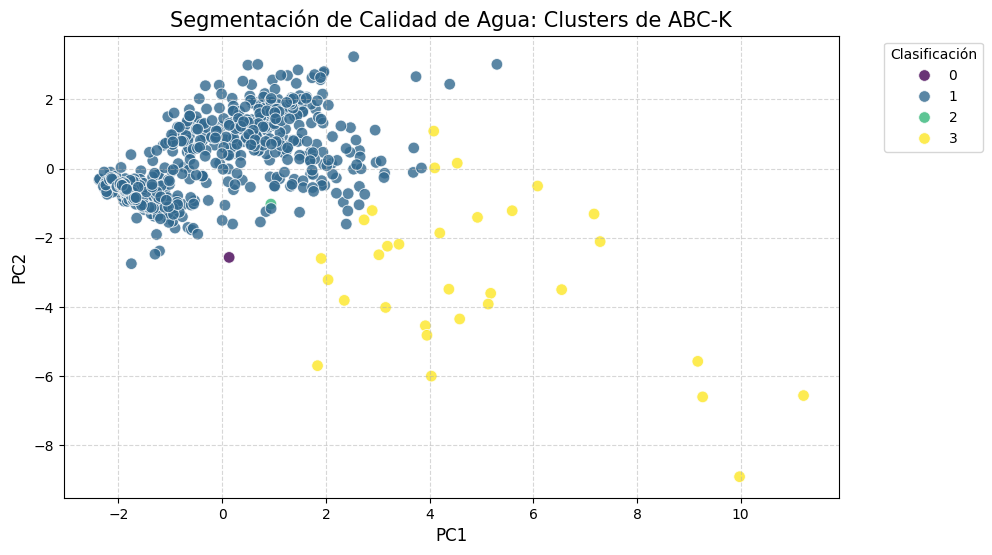

In [97]:
pca_labels = ['PC1', 'PC2']

plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=pca_data, 
    x=pca_labels[0], 
    y=pca_labels[1], 
    hue='cluster_hibrido', 
    palette='viridis', 
    s=70, 
    alpha=0.8,
    edgecolor='w'
)

# Personalización de títulos (basado en tu interpretación de loadings)
plt.title('Segmentación de Calidad de Agua: Clusters de ABC-K', fontsize=15)
plt.xlabel(f'{pca_labels[0]}', fontsize=12)
plt.ylabel(f'{pca_labels[1]}', fontsize=12)
plt.legend(title='Clasificación', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.50)
plt.show()

In [100]:
pca_data.head()
pca_data.to_csv("pca_data_abck.csv", index=False, sep=',', encoding='utf-8')